<a href="https://colab.research.google.com/github/tcows/NLP_study/blob/main/Tweet_Emotion_Recognition_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [114]:
!pip install nlp

In [115]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.15.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [116]:
pip install --upgrade datasets


In [117]:
from datasets import load_dataset

dataset = load_dataset('emotion')
labels_name = dataset['train'].features['label'].names

In [118]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [119]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [120]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [121]:
tweets, labels = get_tweet(train)

In [122]:
mapped_labels = [labels_name[label] for label in labels]

In [123]:
tweets[2], labels_name[2]

('im grabbing a minute to post i feel greedy wrong', 'love')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [124]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [125]:
tokenizer = Tokenizer(num_words=1000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [126]:
tokenizer.texts_to_sequences([tweets[2]])

[[17, 1, 7, 1, 5, 286, 2, 3, 495, 438]]

In [127]:
tweets[2]

'im grabbing a minute to post i feel greedy wrong'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

In [128]:
from collections import Counter

label_counts = Counter(mapped_labels)

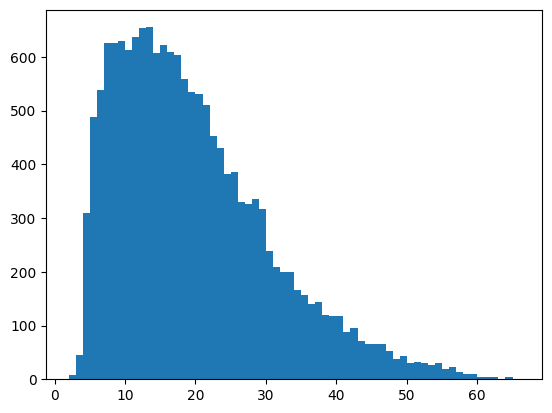

In [129]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [130]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [131]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [132]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [133]:
padded_train_seq[2]

array([ 17,   1,   7,   1,   5, 286,   2,   3, 495, 438,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [134]:
classes= set(label_counts)
print(classes)

{'anger', 'fear', 'surprise', 'love', 'sadness', 'joy'}


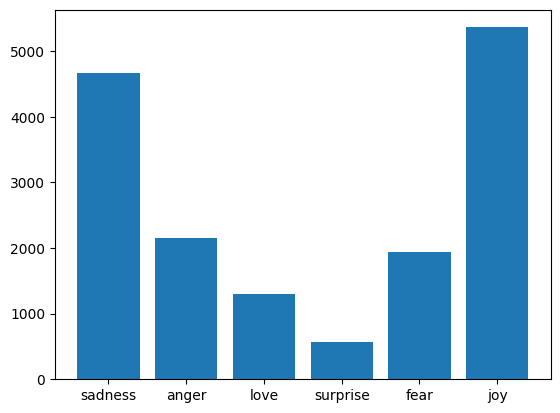

In [135]:
plt.bar(label_counts.keys(), label_counts.values())
plt.show()

In [136]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [137]:
class_to_index

{'anger': 0, 'fear': 1, 'surprise': 2, 'love': 3, 'sadness': 4, 'joy': 5}

In [138]:
index_to_class

{0: 'anger', 1: 'fear', 2: 'surprise', 3: 'love', 4: 'sadness', 5: 'joy'}

In [150]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [152]:
train_labels = names_to_ids(mapped_labels)
print (train_labels[2])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [161]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(1000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
)

In [162]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_12 (Bidirect  (None, 50, 40)            5920      
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 40)                9760      
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 246       
                                                                 
Total params: 31926 (124.71 KB)
Trainable params: 31926 (124.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [163]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids([labels_name[label] for label in val_labels])

In [164]:
val_tweets[2], val_labels[2]

('i feel like a faithful servant', 3)

In [165]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 46s 69ms/step - loss: 1.3769 - accuracy: 0.4458 - val_loss: 0.9962 - val_accuracy: 0.6285
Epoch 2/20
500/500 [==============================] - 29s 59ms/step - loss: 0.7868 - accuracy: 0.7368 - val_loss: 0.6863 - val_accuracy: 0.7815
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.5581 - accuracy: 0.8174 - val_loss: 0.5395 - val_accuracy: 0.8150
Epoch 4/20
500/500 [==============================] - 29s 57ms/step - loss: 0.4671 - accuracy: 0.8364 - val_loss: 0.5147 - val_accuracy: 0.8235
Epoch 5/20
500/500 [==============================] - 29s 57ms/step - loss: 0.4162 - accuracy: 0.8497 - val_loss: 0.4855 - val_accuracy: 0.8260
Epoch 6/20
500/500 [==============================] - 28s 57ms/step - loss: 0.3885 - accuracy: 0.8568 - val_loss: 0.4897 - val_accuracy: 0.8285
Epoch 7/20
500/500 [==============================] - 28s 56ms/step - loss: 0.3404 - accuracy: 0.8759 - val_loss: 0.4434 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

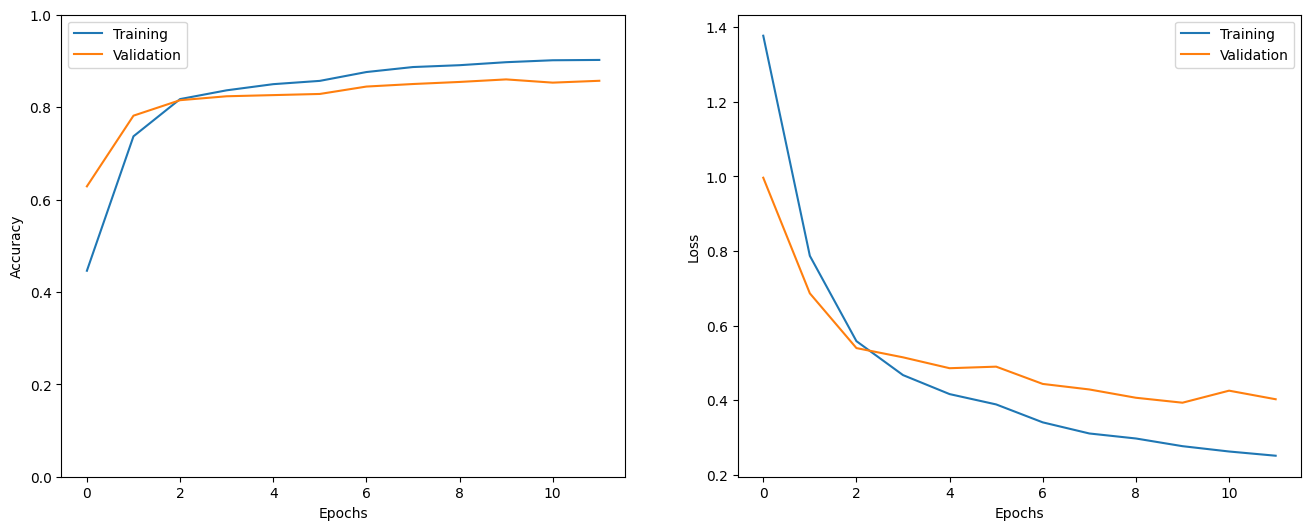

In [169]:
show_history(h)

In [170]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids([labels_name[label] for label in test_labels])

In [171]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 2s 25ms/step - loss: 0.4010 - accuracy: 0.8635


In [175]:
i = random.randint(0, len(test_labels) - 1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i woke up today feeling kind of strange
Emotion: fear
1/1 [==============================] - 0s 27ms/step
Predicted Emotion: fear


In [182]:
preds = model.predict(test_seq)

63/63 [==============================] - 2s 31ms/step


In [183]:
preds_classes = np.argmax(preds, axis=1)

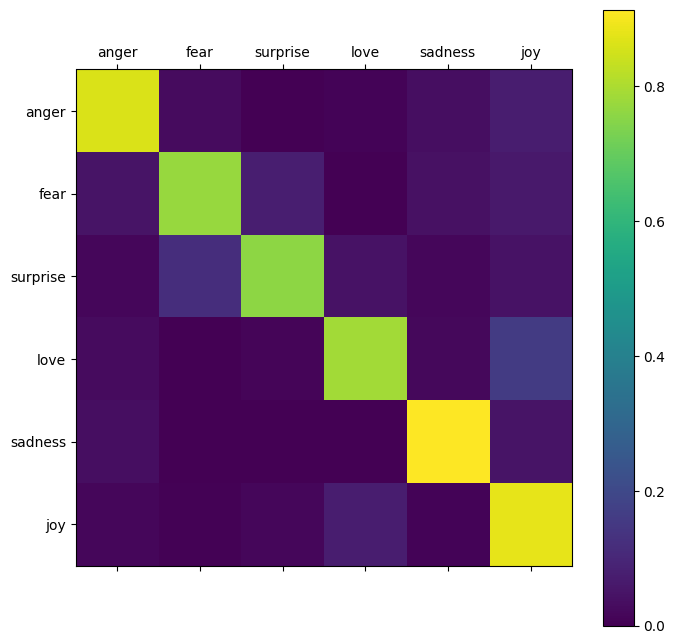

In [184]:
show_confusion_matrix(test_labels, preds_classes, list(classes))